In [2]:
import os

from shapely.geometry import Point
import geopandas as gpd
# from shapely.ops import unary_union
from shapely.geometry import Point
from shapely.ops import nearest_points
# from shapely.ops import nearest_points

from tobler.area_weighted import area_interpolate
# from tobler.dasymetric import masked_area_interpolate

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib_scalebar.scalebar import ScaleBar
import contextily as cx

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats


In [3]:
os.chdir("/Volumes/Extreme SSD/MH_Suitability/dati/32633_data")

In [4]:

# AOI
AOI = gpd.read_file("AOI.gpkg", ignore_fields=['location', 'id', 'objectid', 'cod_pro',
                                               'cod_istat', 'pro_com', 'nome', 'shape_leng', 'shape_area'])

# MUNICIPI
mun = gpd.read_file("ASSETS/municipi_Roma_32633.gpkg")

# CENSUS
census = gpd.read_file("ASSETS/sez_censuarie_2011_Roma_32633.gpkg",
                       ignore_fields=['pro_com', 'cod_stagno','cod_fiume', 
                                      'cod_lago', 'cod_laguna', 'cod_val_p', 'cod_zona_c',
                                      'cod_is_amm', 'cod_is_lac', 'cod_is_mar', 'cod_area_s', 'cod_mont_d',
                                      'loc2011', 'cod_loc', 'tipo_loc', 'com_asc', 'cod_asc', 'ace',
                                      'shape_leng'
                                      ]
                       )

# OMI
omi = gpd.read_file("ASSETS/OMI_Zone_Valori_32633.gpkg",
                    ignore_fields=['LINKZONA', 'CODCOM', 'ZONE_Comune_descrizione',
                           'ZONE_Zona_Descr', 'ZONE_Zona', 'ZONE_LinkZona', 'ZONE_Stato_prev', 'ZONE_Microzona',
                           'VAL_Zona', 'VAL_Fascia', 'VAL_Stato_prev', 'VAL_Sup_NL_compr', 
                           'VAL_Loc_min', 'VAL_Loc_max', 'VAL_Sup_NL_loc'
                           ]
                    )

# BUILDINGS
BUILD = gpd.read_file("ASSETS/dbsn_edifici_AOI_32633.gpkg",
                      ignore_fields=['edifc_sot', 'classid', 'edifc_nome', 'edifc_stat', 
                                     'edifc_at', 'scril', 'meta_ist', 'edifc_mon', 
                                     'shape_Length', 'shape_Area']
                      ).set_index('OBJECTID')


In [5]:
#%% Clip based on AOI
mun_aoi = gpd.clip(mun, AOI)
census_aoi = gpd.clip(census, AOI)
omi_aoi = gpd.clip(omi, AOI)

# delete original gdf
del mun, census, omi

In [6]:
# FUNCTIONS
# Merge categories of "edifc_uso"
def merge_category(cat):
    macro_cats = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '95', '93']
    for macro in macro_cats:
        if cat.startswith(macro):
            return macro
        else:
            pass

def spatial_fill_nan(gdf, col, k=3):
    # creiamo una copia del geodataframe per evitare di modificare l'originale
    filled_gdf = gdf.copy()
    
    # selezioniamo i record con valore nullo nella colonna "VAL_Compr_min"
    null_rows = filled_gdf[filled_gdf[col].isnull()]
        
    # iteriamo sui record con valore nullo
    for idx, row in null_rows.iterrows():
        # selezioniamo i tre poligoni più vicini al punto di interesse
        point = Point(row["geometry"].centroid.x, row["geometry"].centroid.y)
        distances = filled_gdf.distance(point)
        nearest_poly_indices = distances.sort_values().index[:k]
        
        # calcoliamo la media dei valori "VAL_Compr_min" dei tre poligoni vicini
        nearest_vals = filled_gdf[~filled_gdf.index.isin([idx]) & filled_gdf.index.isin(nearest_poly_indices)][col]
        mean_val = nearest_vals.mean()
        
        # sostituiamo il valore nullo con la media dei valori dei poligoni vicini
        filled_gdf.loc[idx, col] = mean_val
        # check remaining NANs and fill them with mean value of the series.
        # filled_gdf.fillna()
    return filled_gdf

def spatial_fill_nan_by_type(gdf, col, col_type='VAL_Descr_Tipologia', k=3):
    # creo empty geodataframe
    result_gdf = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry', crs='EPSG:32633')
    # iterate on types
    types = gdf[col_type].unique()
    for t in types:
        filled_gdf_type = gdf.loc[gdf[col_type] == t]
        # selezioniamo i record con valore nullo nella colonna "VAL_Compr_min"
        null_rows = filled_gdf_type.loc[filled_gdf_type[col].isnull()]
        # iteriamo sui record con valore nullo
        for idx, row in null_rows.iterrows():
            # selezioniamo i tre poligoni più vicini al punto di interesse
            point = Point(row["geometry"].centroid.x, row["geometry"].centroid.y)
            distances = filled_gdf_type.distance(point)
            nearest_poly_indices = distances.sort_values().index[:k]
            
            # calcoliamo la media dei valori "VAL_Compr_min" dei tre poligoni vicini
            nearest_vals = filled_gdf_type[~filled_gdf_type.index.isin([idx]) & filled_gdf_type.index.isin(nearest_poly_indices)][col]
            mean_val = nearest_vals.mean()
            
            # sostituiamo il valore nullo con la media dei valori dei poligoni vicini
            filled_gdf_type.loc[idx, col] = mean_val
            # check remaining NANs and fill them with mean value of the series.
        mean_by_col_type = filled_gdf_type[col].mean()
        filled_gdf_type[col].fillna(mean_by_col_type, inplace=True)
    
        # append to results
        result_gdf = result_gdf.append(filled_gdf_type)
    return result_gdf

# Spatial joint between polygon with the largest area of intersection
def largest_intersection(gdf_left, gdf_right, mode):
    """
    Take two geodataframes, do a spatial join, and return the polygon 
    with the largest area of intersection
    """
    out_gdf = gpd.sjoin(gdf_left, gdf_right, how = "left", predicate = mode).dropna()
    out_gdf['intersection'] = [a.intersection(gdf_right[gdf_right.index == b].geometry.values[0]).area for a, b in zip(out_gdf.geometry.values, out_gdf.index_right)]
    out_gdf['index'] = out_gdf.index
    out_gdf = out_gdf.sort_values(by='intersection')
    out_gdf = out_gdf.drop_duplicates(subset = 'index', keep='last')
    out_gdf = out_gdf.sort_values(by='index')
    out_gdf = out_gdf.drop(columns=['index_right', 'intersection', 'index'])
    
    return out_gdf

In [7]:
## SPATIAL FILL NAN --> Func spatial_fill_nan
most_fr = omi_aoi['VAL_Descr_Tipologia'].mode().iloc[0]
omi_aoi['VAL_Descr_Tipologia'].fillna(most_fr, inplace=True)
omi_20 = omi_aoi[omi_aoi['VAL_Descr_Tipologia'].isin(['Abitazioni civili', 'Ville e Villini'])]
omi_20_fill = spatial_fill_nan(omi_20, "VAL_Compr_min", k=3)
omi_20_fill_ok = spatial_fill_nan(omi_20_fill, "VAL_Compr_max", k=3)
omi_20_nan = omi_20_fill_ok[omi_20_fill_ok['VAL_Cod_Tip'].isna()]
# assign filled values to original omi_aoi
omi_aoi['VAL_Compr_min'].fillna(omi_20_nan['VAL_Compr_min'], inplace=True)
omi_aoi['VAL_Compr_max'].fillna(omi_20_nan['VAL_Compr_max'], inplace=True)
del most_fr, omi_20, omi_20_fill, omi_20_fill_ok, omi_20_nan
# save omi_aoi
# omi_aoi.to_file("ASSETS/pre-processed/OMI_AOI.gpkg", driver='GPKG')

In [8]:
## Spatial Join BUILD-OMI 
# select unique omi polygons with codzona attribute
omi_codzona = omi_aoi[['CODZONA', 'geometry']].sort_index().drop_duplicates(subset=['CODZONA', 'geometry'])
# spatial join one-to-one BUILD with omi_codzona
builds_codzona = largest_intersection(BUILD, omi_codzona, 'intersects')
## Buildings Macro Categories
builds_codzona['edifc_uso_macro'] = builds_codzona['edifc_uso'].apply(merge_category)
builds_codzona = builds_codzona.reset_index()
del BUILD

In [9]:
# MAP Cod_Tip and Edific_Uso
# corrispondenze valori edifc_uso, VAL_Cod_Tip
edifc_uso_map = {'01':'Abitazioni civili',
                 '02':'Uffici',
                 # '03': 'Abitazioni di tipo economico',
                 '03': 'Uffici',
                 '04': 'Uffici',
                 '05': '-',
                 '06': 'Abitazioni di tipo economico',
                 '07': 'Negozi',
                 '08': 'Capannoni industriali',
                 '09': 'Capannoni tipici',
                 '10': 'Abitazioni di tipo economico', # o abitazioni civili
                 '11': 'Abitazioni di tipo economico',
                 '12': 'Abitazioni di tipo economico', # o abitazioni civili
                 '95':'-',
                 '93':'-'}


In [10]:
# map
builds_codzona['VAL_Descr_Tipologia'] = builds_codzona['edifc_uso_macro'].map(edifc_uso_map)
# drop '-'
builds_codzona = builds_codzona.drop(builds_codzona[builds_codzona['VAL_Descr_Tipologia'] == '-'].index)

In [11]:
# MERGE [VAL_Compr_min, VAL_Compr_max] on [CODZONA, VAL_Cod_Tip]
builds_w_val = builds_codzona.merge(omi_aoi, on=['CODZONA','VAL_Descr_Tipologia'], how='left',
                                    ).drop(columns=['geometry_y']
                                           # ).set_index('OBJECTID'
                                           ).rename(columns={'geometry_x': 'geometry'}
                                                    ).set_geometry('geometry')
                                                    # drop useless columns
# sort values and drop_duplicates keeping last
builds_w_val = builds_w_val.sort_values(by=['OBJECTID', 'VAL_Compr_min']
                                        ).drop_duplicates(subset=['OBJECTID'], keep='last')


In [12]:
#check for NaNs
print(builds_w_val.isna().sum())

OBJECTID                  0
edifc_uso                 0
edifc_ty                  0
geometry                  0
CODZONA                   0
edifc_uso_macro           0
VAL_Descr_Tipologia       0
Name                   4074
ZONE_Fascia            4074
ZONE_Cod_tip_prev      4074
ZONE_Descr_tip_prev    4074
VAL_Cod_Tip            4456
VAL_Stato              4456
VAL_Compr_min          4074
VAL_Compr_max          4074
dtype: int64


In [13]:
# Fill NaNs with knn
builds_w_val_filled = spatial_fill_nan_by_type(builds_w_val, 'VAL_Compr_min', col_type='VAL_Descr_Tipologia', k=10)
builds_w_val_filled2 = spatial_fill_nan_by_type(builds_w_val_filled, 'VAL_Compr_max', col_type='VAL_Descr_Tipologia', k=10)
del builds_w_val_filled

/var/folders/j3/ht1nhdx57gz8mgg616ylchmm0000gn/T/ipykernel_94740/835085651.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_gdf = result_gdf.append(filled_gdf_type)
/var/folders/j3/ht1nhdx57gz8mgg616ylchmm0000gn/T/ipykernel_94740/835085651.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_gdf = result_gdf.append(filled_gdf_type)
/var/folders/j3/ht1nhdx57gz8mgg616ylchmm0000gn/T/ipykernel_94740/835085651.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_gdf = result_gdf.append(filled_gdf_type)
/var/folders/j3/ht1nhdx57gz8mgg616ylchmm0000gn/T/ipykernel_94740/835085651.py:62: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

In [14]:
#drop useless cols
cols_to_drop = ['Name', 'ZONE_Fascia', 'ZONE_Cod_tip_prev', 'ZONE_Descr_tip_prev', 'VAL_Cod_Tip', 'VAL_Stato']
builds_w_val_filled_ok = builds_w_val_filled2.drop(cols_to_drop, axis=1)
# drop nan
builds_w_val_filled_ok.dropna(inplace=True)

# save builds_w_val
# builds_w_val_filled_ok.to_file("ASSETS/pre-processed/builds_w_val_filled_by_type_new.gpkg", driver='GPKG')

In [15]:
# Filter on condition
# builds_w_val_filled_ok = gpd.read_file("ASSETS/pre-processed/builds_w_val_filled_by_type_new.gpkg")
condition = ((builds_w_val_filled_ok['edifc_uso_macro'] == '10') & builds_w_val_filled_ok['edifc_ty'].isin(['11', '12', '15', '16', '95']))
builds_w_omi = builds_w_val_filled_ok.drop(builds_w_val_filled_ok[condition].index)
#save gdf
# builds_w_omi.to_file("ASSETS/pre-processed/builds_w_omi_all.gpkg", driver='GPKG')

In [16]:
#%% SJOIN BUILDS w CENSUS
# spatial join one-to-one between buildings and census.
cols_of_interest = ['id', 'geometry']
cens_id = census_aoi[cols_of_interest].rename(columns={'id':'c_parcel_id'})
builds_w_all = largest_intersection(builds_w_omi, cens_id, 'intersects')
# drop rows with VAL_Descr_Tipologia == '-'.
builds_w_all = builds_w_all.drop(builds_w_all[builds_w_all['VAL_Descr_Tipologia'] == '-'].index)

# builds_w_all.to_file("ASSETS/pre-processed/builds_w_all.gpkg", driver='GPKG')


In [17]:
# mean market value
builds_w_all['Average_Value'] = (builds_w_all['VAL_Compr_max']+builds_w_all['VAL_Compr_min'])/2

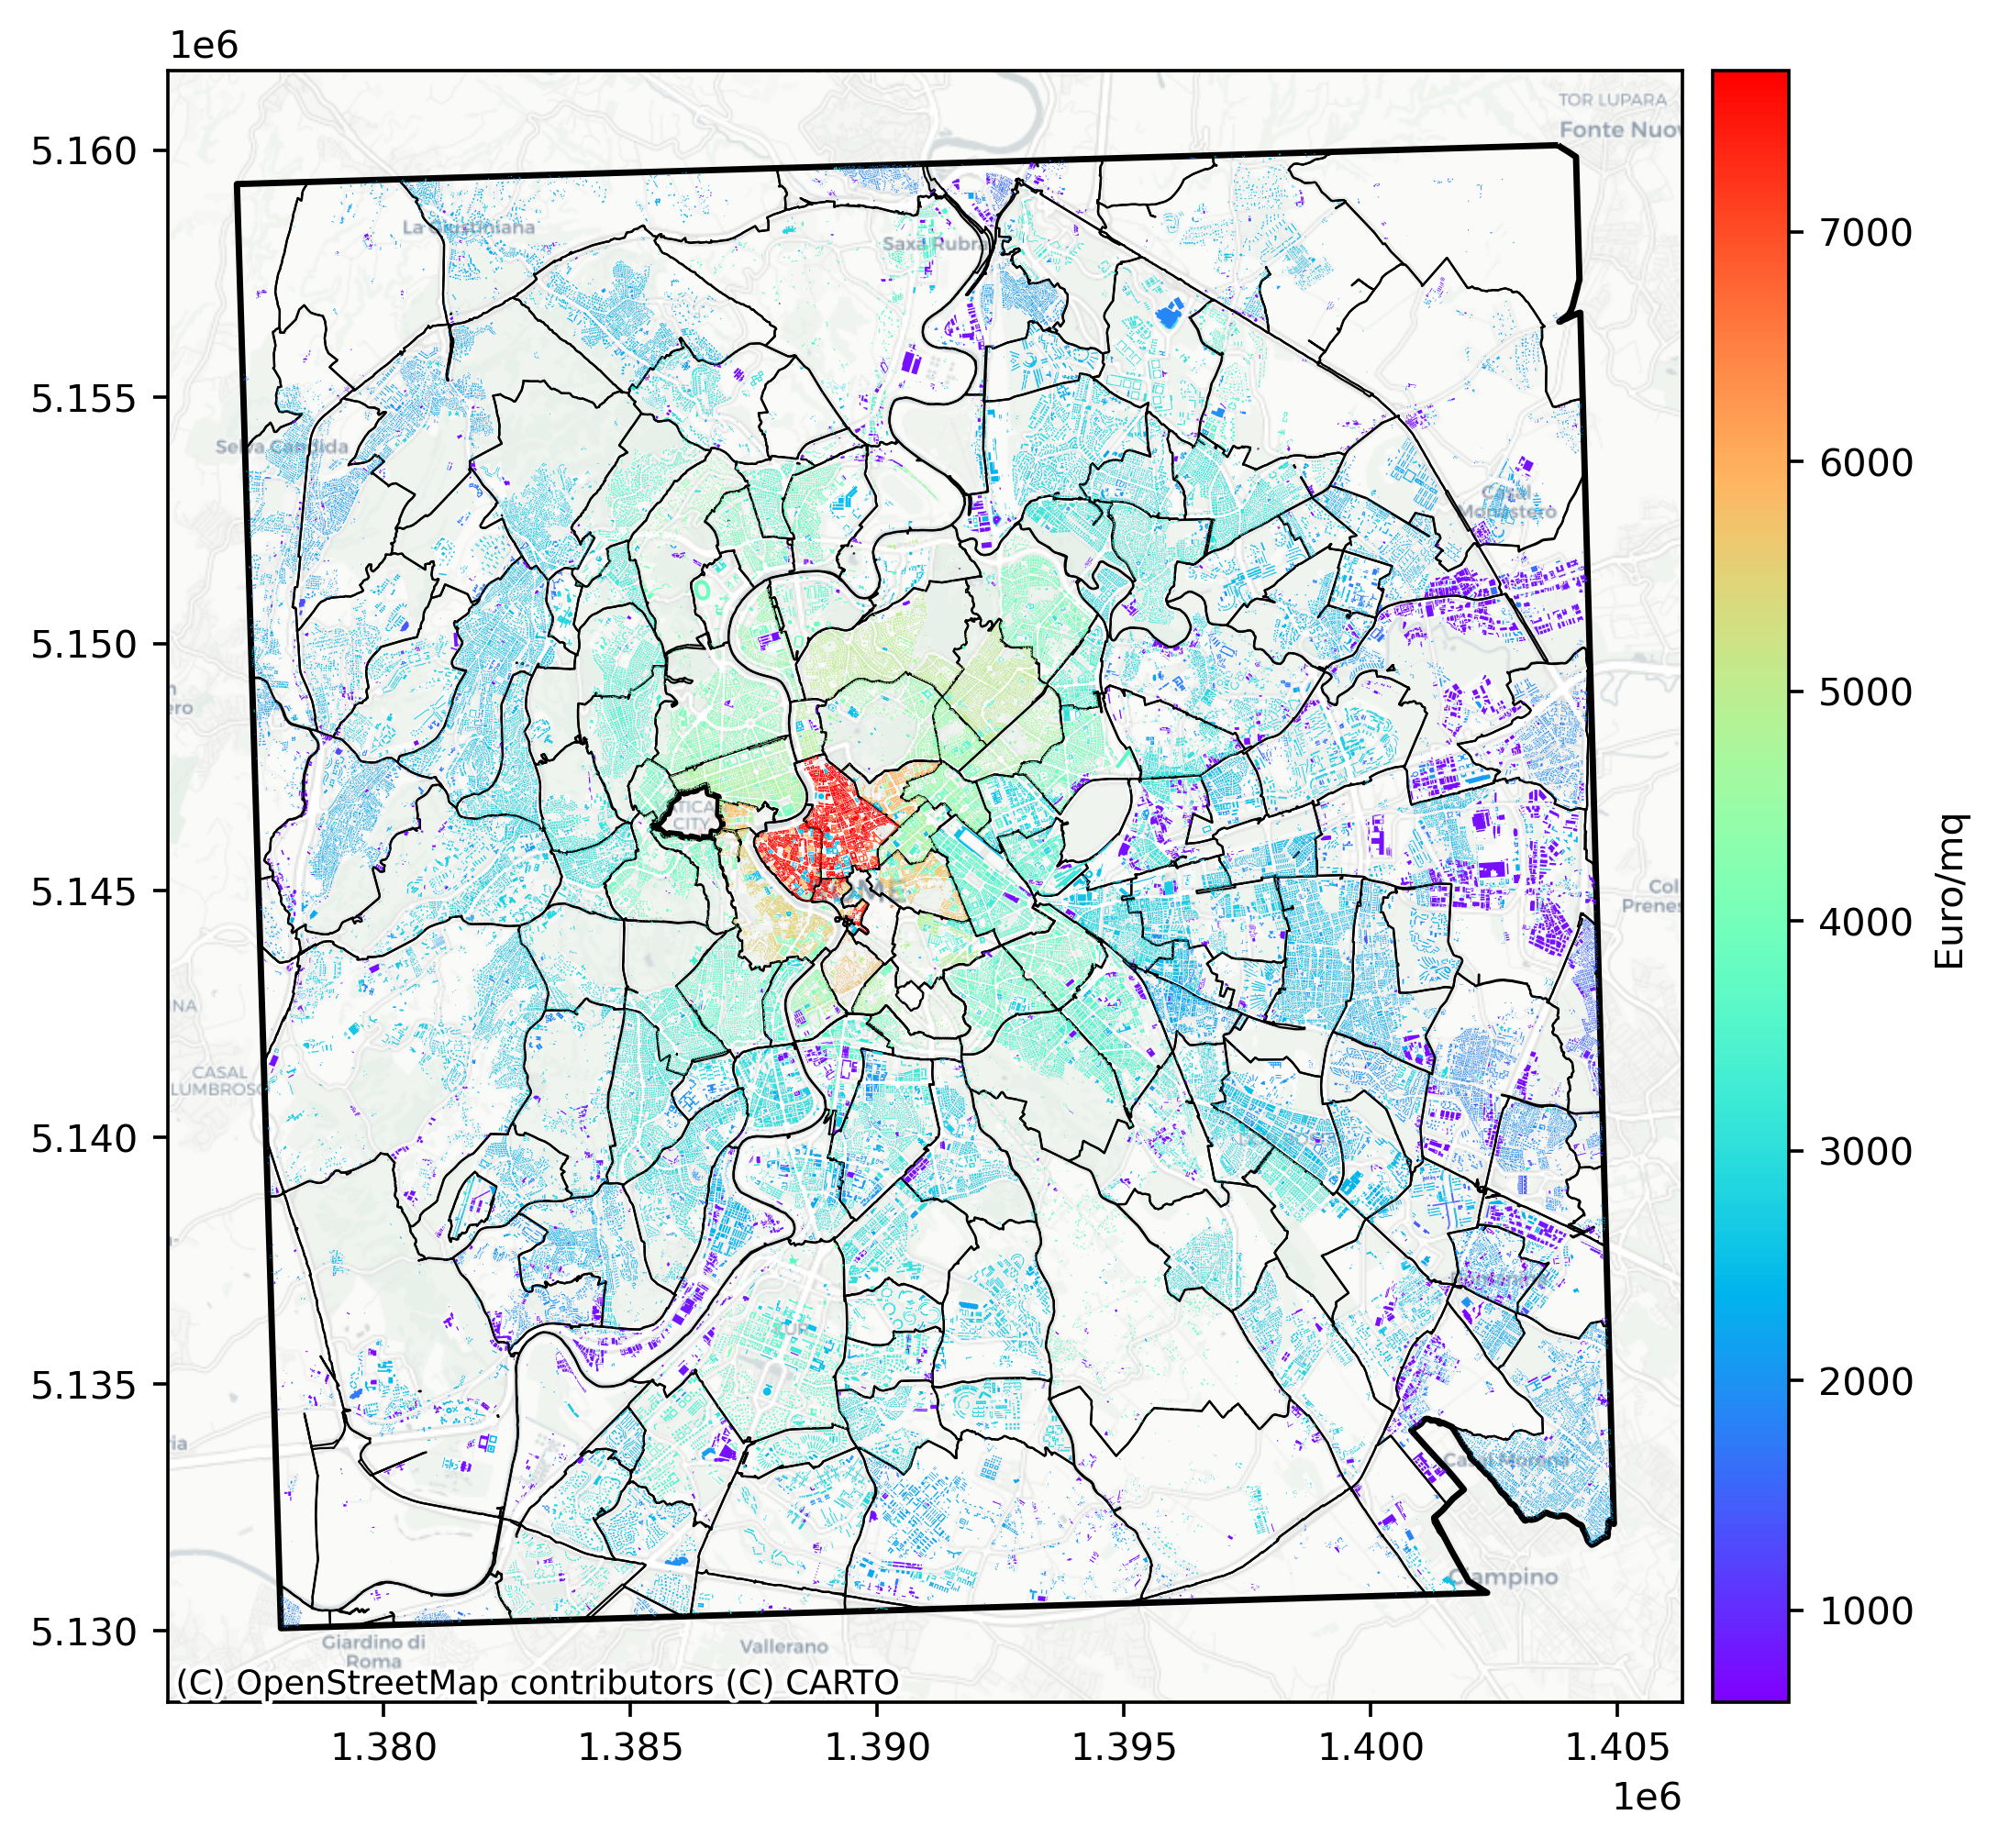

In [21]:
# PLOT VECTORS

# font = {'family' : 'Sans Serif',
#         'size'   : 18}
# plt.rc('font', **font)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=10)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=11)  # fontsize of the figure title

fig, ax = plt.subplots(figsize=(7, 7), dpi=330, facecolor='w', edgecolor='k')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cx_crs = 'EPSG:3857'
AOI.to_crs(cx_crs).boundary.plot(ax=ax, color='k')
omi_codzona.to_crs(cx_crs).boundary.plot(ax=ax, color='k', lw=0.5, zorder=1)

builds_w_all.to_crs(cx_crs).plot(ax=ax, column='Average_Value', cmap='rainbow', zorder=2,
                          legend=True, cax=cax, legend_kwds={'label':'Euro/m2',
                                                    'orientation':'vertical'})


# interp_build.plot(ax=ax, column='VAL_Compr_max_fill', linewidth=0.1)

# add basemap
# cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite)
# cx.add_basemap(ax, source=cx.providers.Esri.WorldTerrain) #WorldTerrain, WorldShadedRelief
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

# set labels, title and legend
# plt.title('Building Value', fontsize=32)
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# add scalebar
# ax.add_artist(ScaleBar(2, location='lower right', box_color='w', font_properties={'size':'large'}))

# SAVE
# PLOT_NAME= 'Building Value by location and type'
# plt.savefig(os.path.join(path, '{}.tiff').format(PLOT_NAME), format='tiff', bbox_inches='tight', pad_inches=0.2)

plt.show()


In [19]:
#%% SPATIAL INTERPOLATION WITH TOBLER
# interpolation = area_interpolate(source_df=omi_aoi, target_df=census_aoi, intensive_variables=['VAL_Compr_min_fill'])
# interpolation.to_file("tests/census_w_omi_spatial_interpolation.gpkg", driver='GPKG', layer='name')

# buildings
# interp_build = area_interpolate(omi_aoi, BUILD, intensive_variables=['VAL_Compr_min_fill', 'VAL_Compr_max_fill'])
# interp_build.to_file("tests/builds_w_omi_spatial_interpolation.gpkg", driver='GPKG', layer='name')